In [237]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
import seaborn as sn

# Word Clouds

In [42]:
# create df
data = pd.read_excel('cleaned_users.xlsx')
username_list = data['username']

texts = []
for username in username_list:
    with open(f'Cleaned Documents/{username}.txt','r') as f:
        texts.append(f.read().replace('\n',' ').lower())

data['text'] = texts

In [43]:
data.head()

,username,gender,age,region,text
0,lozanogarcia68,female,55+,Madrid,que pena la deriva que esta tomando el balonce...
1,beltrangmodet,male,18-24,Madrid,aranza - jensen. lebronpadelclub su...
2,edubellver,male,18-24,Madrid,¿¿ mueves tu sucio trasero esta tarde/noche p...
3,luss_27,female,18-24,Madrid,"hoy me han dicho una cosa : ""esta bien no sabe..."
4,k15ce,male,25-34,Madrid,creo que es uno de los dias que mas orgulloso ...


In [56]:
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ü","u"),
        ("ñ","n"),
        ("ç","c"),
        ("\u2026","..."),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [59]:
# load spanish stop words and remove accents (tweets dont have accents)
stop_words_df = pd.read_csv('spanish-stop-words.txt',header=None)
stop_words = [normalize(w) for w in list(stop_words_df[0])] + ['q','ma']

### Gender

In [62]:
text_female = " ".join(text for gender,text_list in data.groupby(['gender'])['text'] if gender == 'female' for text in text_list)
text_male = " ".join(text for gender,text_list in data.groupby(['gender'])['text'] if gender == 'male' for text in text_list)

# create and generate word cloud
wordcloud_fem = WordCloud(stopwords=stop_words,background_color='white',max_words=100).generate(text_female)
wordcloud_male = WordCloud(stopwords=stop_words,background_color='white',max_words=100).generate(text_male)

# save image
wordcloud_fem.to_file("WordClouds/gender/female.png")
wordcloud_male.to_file("WordClouds/gender/male.png")

'# display image\nprint(\'FEMALE\')\nplt.imshow(wordcloud_fem, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()\nprint(\'MALE\')\nplt.imshow(wordcloud_male, interpolation=\'bilinear\')\nplt.axis("off")\nplt.show()'

### Age

In [63]:
for age_group in data['age'].unique():
    final_text = " ".join(text for age,text_list in data.groupby(['age'])['text'] if age == age_group for text in text_list)
    # create and generate word cloud
    wordcloud = WordCloud(stopwords=stop_words,background_color='white',max_words=100).generate(final_text)

    # save image
    wordcloud.to_file(f"WordClouds/age/{age_group}.png")

### Region

In [65]:
for region_group in data['region'].unique():
    final_text = " ".join(text for region,text_list in data.groupby(['region'])['text'] if region == region_group for text in text_list)
    # create and generate word cloud
    wordcloud = WordCloud(stopwords=stop_words,background_color='white',max_words=100).generate(final_text)

    # save image
    wordcloud.to_file(f"WordClouds/region/{region_group}.png")

# N-Gram Analysis

1. Calculate vector for each tweet
2. Calculate average of vectors and compute author's vector
3. Calculate vector for each group: female_vector, male_vector...
4. Calculate distance between vectors using cosine similarity: if distance is big, it is statistically significant that the feature (gender, age, region) and the style of writing are dependant.

Compute 3 different vectors:
- Word 2 vec: unigram and bigram
- Char 2 vec: number of characters varying between 2 and 7, without word boundaries

In [117]:
# create df
data = pd.read_excel('cleaned_users.xlsx')
username_list = data['username']

texts = []
for username in username_list:
    with open(f'Cleaned Documents/{username}.txt','r') as f:
        texts.append(f.read())

data['text'] = texts

Obtain optimal number of components to reduce vector dimension to that number.

*explained_variance_ratio* gives a number between 0 and 1, the closer to 1, the better the vector represents (explains) the document

In [138]:
vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2))
count = 0
suma = 0
for document in data['text']:
    tweets = document.split('\n')
    # only consider users with 90 or more tweets
    if len(tweets) >= 90:
        tfidf_matrix = vectorizer.fit_transform(tweets)
        # normalize matrix to perform PCA
        matrix = tfidf_matrix.todense()
        matrix_df = pd.DataFrame(matrix)
        matrix_df = matrix_df - matrix_df.mean()
        # perform PCA to reduce dimensionality (vector of dim=90 for each tweet)
        pca = PCA(n_components=90)
        pca.fit(matrix_df)
        # how much information is lost
        suma += sum(pca.explained_variance_ratio_)
        count += 1

print(suma/count)
print(count)
print(len(data['text']))

0.8405595355591524
1034
1146


In [139]:
wordgram = []
vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2))

for document in data['text']:
    tweets = document.split('\n')
    # only consider users with 90 or more tweets
    if len(tweets) >= 90:
        tfidf_matrix = vectorizer.fit_transform(tweets)
        # normalize matrix to perform PCA
        matrix = tfidf_matrix.todense()
        matrix_df = pd.DataFrame(matrix)
        matrix_df = matrix_df - matrix_df.mean()
        # perform PCA to reduce dimensionality (vector of dim=85 for each tweet)
        pca = PCA(n_components=90)
        final_matrix = pd.DataFrame(pca.fit_transform(matrix_df))
        # obtain author's vector by averaging the vectors of their tweets
        author_vector = np.array(final_matrix.mean(axis=0))
        wordgram.append(author_vector)

    else:
        wordgram.append(None)

data['wordgram'] = wordgram
        

In [140]:
vectorizer = TfidfVectorizer(analyzer='char',ngram_range=(2,7))
count = 0
suma = 0
for document in data['text']:
    tweets = document.split('\n')
    # only consider users with 90 or more tweets
    if len(tweets) >= 90:
        tfidf_matrix = vectorizer.fit_transform(tweets)
        # normalize matrix to perform PCA
        matrix = tfidf_matrix.todense()
        matrix_df = pd.DataFrame(matrix)
        matrix_df = matrix_df - matrix_df.mean()
        # perform PCA to reduce dimensionality (vector of dim=83 for each tweet)
        pca = PCA(n_components=90)
        pca.fit(matrix_df)
        # how much information is lost
        suma += sum(pca.explained_variance_ratio_)
        count += 1

print(suma/count)
print(count)
print(len(data['text']))

0.8492693198152949
1034
1146


In [141]:
chargram = []
vectorizer = TfidfVectorizer(analyzer='char',ngram_range=(2,7))

for document in data['text']:
    tweets = document.split('\n')
    # only consider users with 90 or more tweets
    if len(tweets) >= 90:
        tfidf_matrix = vectorizer.fit_transform(tweets)
        # normalize matrix to perform PCA
        matrix = tfidf_matrix.todense()
        matrix_df = pd.DataFrame(matrix)
        matrix_df = matrix_df - matrix_df.mean()
        # perform PCA to reduce dimensionality (vector of dim=83 for each tweet)
        pca = PCA(n_components=90)
        final_matrix = pd.DataFrame(pca.fit_transform(matrix_df))
        # obtain author's vector by averaging the vectors of their tweets
        author_vector = np.array(final_matrix.mean(axis=0))
        chargram.append(author_vector)

    else:
        chargram.append(None)

data['chargram'] = chargram
        

In [230]:
data.head()

,username,gender,age,region,text,wordgram,chargram
0,lozanogarcia68,female,55+,Madrid,Que pena la deriva que esta tomando el balonce...,None,None
1,beltrangmodet,male,18-24,Madrid,Aranza - Jensen.\nLebronPadelClub su ambicion....,None,None
2,edubellver,male,18-24,Madrid,¿¿ Mueves tu sucio trasero esta tarde/noche pa...,None,None
3,luss_27,female,18-24,Madrid,"Hoy me han dicho una cosa : ""esta bien no sabe...","[5.6789368529346e-17, -2.888162418775421e-17, ...","[4.212030334652458e-17, -8.277978692380553e-18..."
4,k15ce,male,25-34,Madrid,Creo que es uno de los dias que mas orgulloso ...,"[-7.101225825512397e-17, 8.46672375430882e-18,...","[-8.192987572778535e-17, 4.1569703846343306e-1..."


## Cosine similarity

In [240]:
def cosine_similarity(vec1,vec2):
    A = np.array(vec1)
    B = np.array(vec2)

    dot_prod = np.dot(A,B)
    magA = np.linalg.norm(A)
    magB = np.linalg.norm(B)

    return abs(dot_prod/(magA*magB))

### Gender

In [241]:
gram_list = ['wordgram','chargram']
for gram in gram_list:
    for gender, wordgram_list in data.groupby(['gender'])[gram]:
        df_aux = pd.DataFrame(wordgram_list)
        df_aux.dropna(inplace=True)
        matrix_aux = [vec for vec in df_aux[gram]]
        matrix = np.matrix(matrix_aux)
        if gender == 'female':
            female_vec = np.asarray(matrix.mean(0)).tolist()[0]
        else:
            male_vec = np.asarray(matrix.mean(0)).tolist()[0]


    cosine_sim = cosine_similarity(female_vec, male_vec)
    print(f'Cosine similarity for gender {gram}: {cosine_sim}')

Cosine similarity for gender wordgram: 0.21199445270622289
Cosine similarity for gender chargram: 0.1693877866749191


***Conclusions:*** 

We can see how for word-gram and char-gram, the cosine similarity is practically below 0.2. This means the computed vectors for female and male users aren't similar. Therefore there is enough statistical evidence to refuse the hypothesis that gender and writing topics are independent (meaning, female users and males write about different topics)

### Age

Cosine similarity for age wordgram:



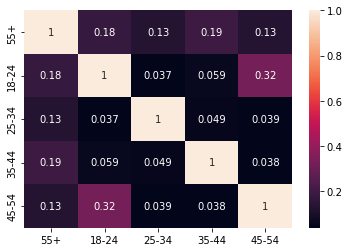

Cosine similarity for age chargram:



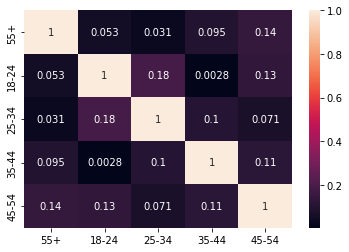

In [242]:
age_group = data['age'].unique()

for gram in gram_list:
    matrix_aux = []
    for age, wordgram_list in data.groupby(['age'])[gram]:
        df_aux = pd.DataFrame(wordgram_list)
        df_aux.dropna(inplace=True)
        matrix = np.matrix([vec for vec in df_aux[gram]])
        matrix_aux.append(np.asarray(matrix.mean(0)).tolist()[0])

    matrix = []
    for vec1 in matrix_aux:
        cosine_sim_row = []
        for vec2 in matrix_aux:
            cosine_sim_row.append(cosine_similarity(vec1, vec2))
        matrix.append(cosine_sim_row)
        
    print(f'Cosine similarity for age {gram}:\n')
    cosine_df = pd.DataFrame(matrix,index=age_group,columns=age_group)
    sn.heatmap(cosine_df,annot=True)
    plt.show()

***Conclusions:*** 

We can see how for word-gram and char-gram, the cosine similarity is below 0.2 (in absolute value) for every combination of different groups, except for 18-24 with 45-54 in word-ngram. This means the computed vectors for the different age groups aren't similar (except for the already mentioned exception). Therefore there is enough statistical evidence to refuse the hypothesis that age and writing topics are independent (meaning, users of different age groups write about different topics)

### Region

Cosine similarity for region wordgram:



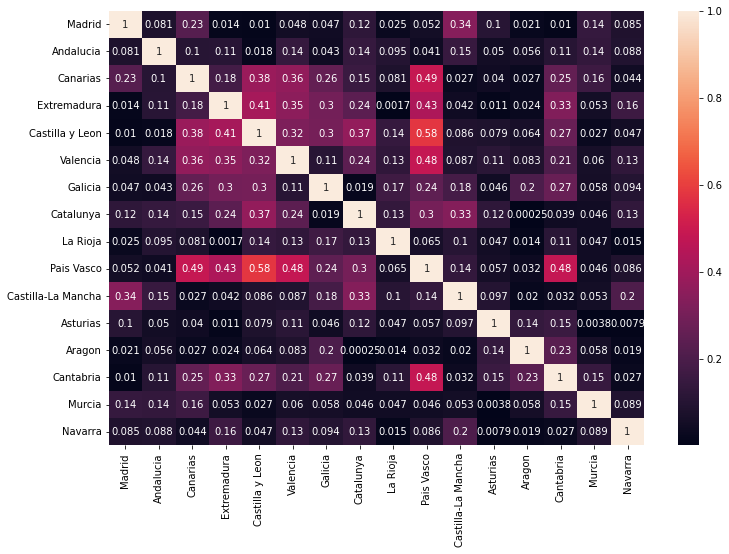

Cosine similarity for region chargram:



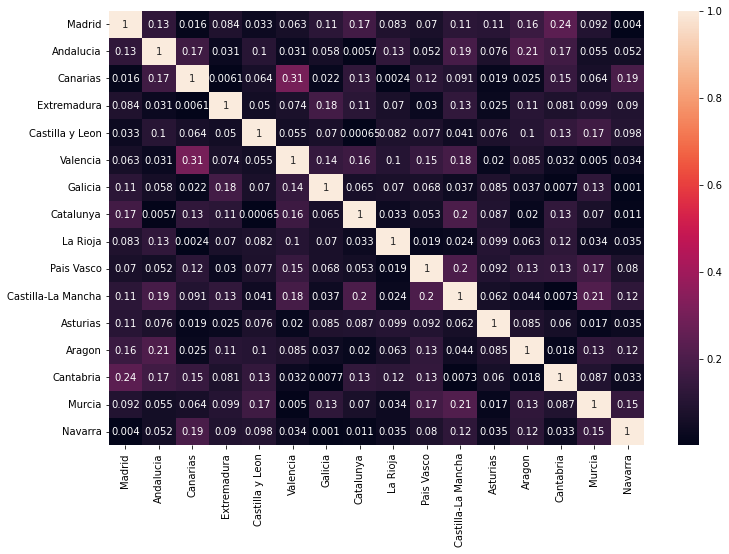

In [245]:
region_group = data['region'].unique()

for gram in gram_list:
    matrix_aux = []
    for region, wordgram_list in data.groupby(['region'])[gram]:
        df_aux = pd.DataFrame(wordgram_list)
        df_aux.dropna(inplace=True)
        matrix = np.matrix([vec for vec in df_aux[gram]])
        matrix_aux.append(np.asarray(matrix.mean(0)).tolist()[0])

    matrix = []
    for vec1 in matrix_aux:
        cosine_sim_row = []
        for vec2 in matrix_aux:
            cosine_sim_row.append(cosine_similarity(vec1, vec2))
        matrix.append(cosine_sim_row)
        
    print(f'Cosine similarity for region {gram}:\n')
    cosine_df = pd.DataFrame(matrix,index=region_group,columns=region_group)
    plt.figure(figsize = (12,8))
    sn.heatmap(cosine_df,annot=True)
    plt.show()